# 05. Visualization

This notebook visualizes the processed data and graph structures, including POI distributions, land use, and metapaths.

In [ ]:
"""
# Colab setup (optional)
!git clone https://github.com/c2g-dev/city2graph-case-study.git

import os
REPO_DIR = "/content/city2graph-case-study"
os.chdir(REPO_DIR)

# delete data directory
!rm -rf /content/city2graph-case-study/data

# download data zip from Zenodo and unzip into data/
!wget -O /content/city2graph-case-study/data.zip https://zenodo.org/records/18396286/files/data.zip?download=1
!unzip -o /content/city2graph-case-study/data.zip -d /content/city2graph-case-study/

!pip install torch_geometric
!pip install city2graph
!pip install contextily

os.chdir(REPO_DIR + "/notebooks")
"""

In [2]:
import os

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap

# Set plot style
plt.style.use('default')

# Paths
DATA_DIR = "../data"
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
RAW_DIR = os.path.join(DATA_DIR, "raw")
OUTPUT_DIR = os.path.join(DATA_DIR, "outputs")

FEATURES_DIR = os.path.join(PROCESSED_DIR, "features")
GRAPHS_DIR = os.path.join(PROCESSED_DIR, "graphs")

FIGURES_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIGURES_DIR, exist_ok=True)

In [11]:
# OA node feature columns (fixed list for this case study)
OA_FEATURE_COLS = [
    "arts_culture",
    "automotive_facility",
    "consumer_service",
    "corporate_service",
    "education",
    "entertainment",
    "food_beverage",
    "healthcare",
    "hotel_lodging",
    "industrial_service",
    "park",
    "public_service",
    "religion",
    "retail",
    "sports_fitness",
    "transportation_facility"
]

## 1. POI Visualization
Visualize POI density/categories across OAs.

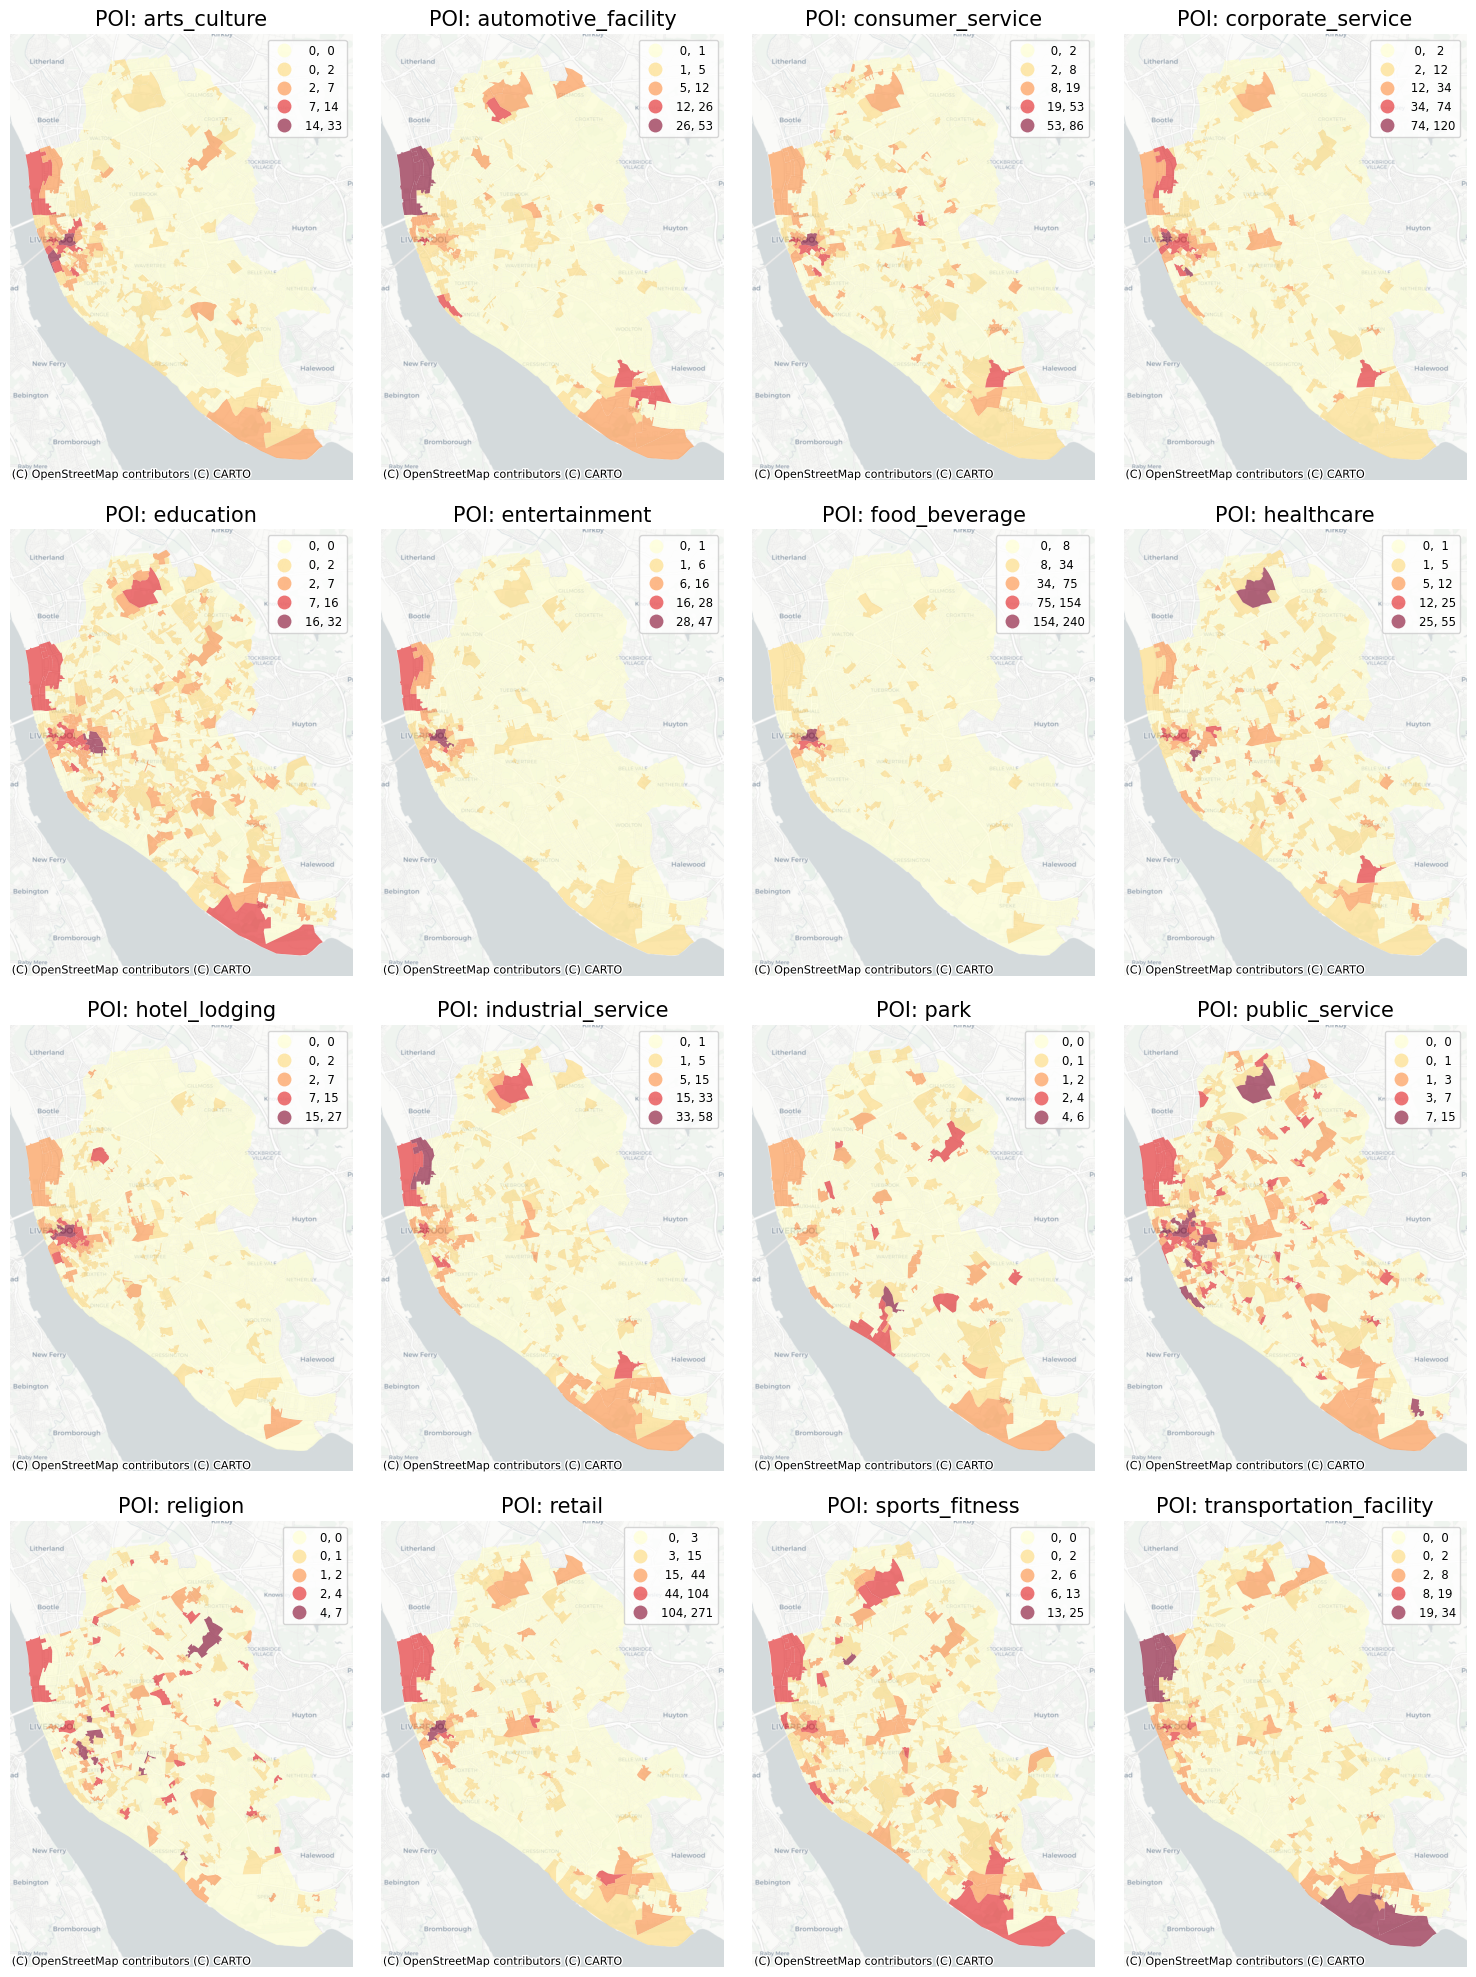

In [ ]:
# Load OA features
oa_features_path = os.path.join(FEATURES_DIR, "oa_with_features.gpkg")
oa_with_features = gpd.read_file(oa_features_path)

# Filter for numeric columns only to avoid TypeError in plotting
categories = [c for c in oa_with_features.columns if c in OA_FEATURE_COLS and pd.api.types.is_numeric_dtype(oa_with_features[c])]
n_cols = 4
n_rows = (len(categories) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categories):
    oa_with_features.to_crs("EPSG:3857").plot(
        column=col,
        ax=axes[i],
        scheme='NaturalBreaks',
        k=5,
        legend=True, 
        cmap='YlOrRd',
        alpha=0.6,
        linewidth=0,
        legend_kwds={'loc': 'upper right', 'fmt': "{:.0f}", 'fontsize': 'small'}
    )

    # Add the basemap to each axis
    ctx.add_basemap(axes[i], source=ctx.providers.CartoDB.Positron)
    
    axes[i].set_title(f'POI: {col}', fontsize=15)
    axes[i].set_axis_off()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "poi.png"), bbox_inches='tight')
plt.show()

## 2. Land Use Visualization
Visualize land use classes with a custom color palette.

In [8]:
# Load Land Use Data
land_use_path = "../data/raw/overture/land_uses.gpkg"
land_uses = gpd.read_file(land_use_path)

# Define Category Mapping (Class -> Functional Group)
LAND_USE_MAPPING = {
    'residential': ['residential', 'garages'],
    'commercial': ['commercial', 'retail', 'plaza'],
    'industrial': ['industrial', 'works', 'brownfield', 'construction'],
    'public_services': ['school', 'university', 'college', 'hospital', 'clinic', 'doctors', 'religious', 'military', 'base', 'cemetery', 'grave_yard'],
    'green_space': ['park', 'grass', 'garden', 'meadow', 'nature_reserve', 'village_green', 'green', 'greenfield', 'flowerbed', 'orchard', 'allotments', 'recreation_ground', 'playground', 'pitch', 'stadium', 'golf_course', 'fairway', 'tee', 'bunker', 'rough', 'water_hazard'],
    'transportation': ['railway', 'track', 'pedestrian'],
    'agricultural': ['farmland', 'farmyard'],
    'other': []
}

# HELPER: REVERSE LOOKUP
def get_reverse_mapping(mapping_dict):
    """
    Generates a dictionary where Keys = Specific Types (e.g. 'residential')
    and Values = Category (e.g. 'residential').
    """
    reverse_map = {}
    duplicates = []
    for category, items in mapping_dict.items():
        for item in items:
            if item in reverse_map:
                duplicates.append(f"{item} (found in {reverse_map[item]} and {category})")
            reverse_map[item] = category
    if duplicates:
        print(f"Warning: Found duplicates in mapping: {duplicates}")
    return reverse_map

LAND_USE_TO_CLASS = get_reverse_mapping(LAND_USE_MAPPING)

def map_land_use_class(cls):
    """Maps a detailed land use class to a broader functional class."""
    if pd.isna(cls):
        return 'other'
    return LAND_USE_TO_CLASS.get(cls, 'other')

# Apply the mapping
land_uses['land_use_class'] = land_uses['class'].apply(map_land_use_class)

# Inspect mapped classes
print(land_uses['land_use_class'].value_counts())


land_use_class
green_space        4184
residential         462
industrial          292
public_services     254
transportation      222
commercial          212
agricultural         39
Name: count, dtype: int64


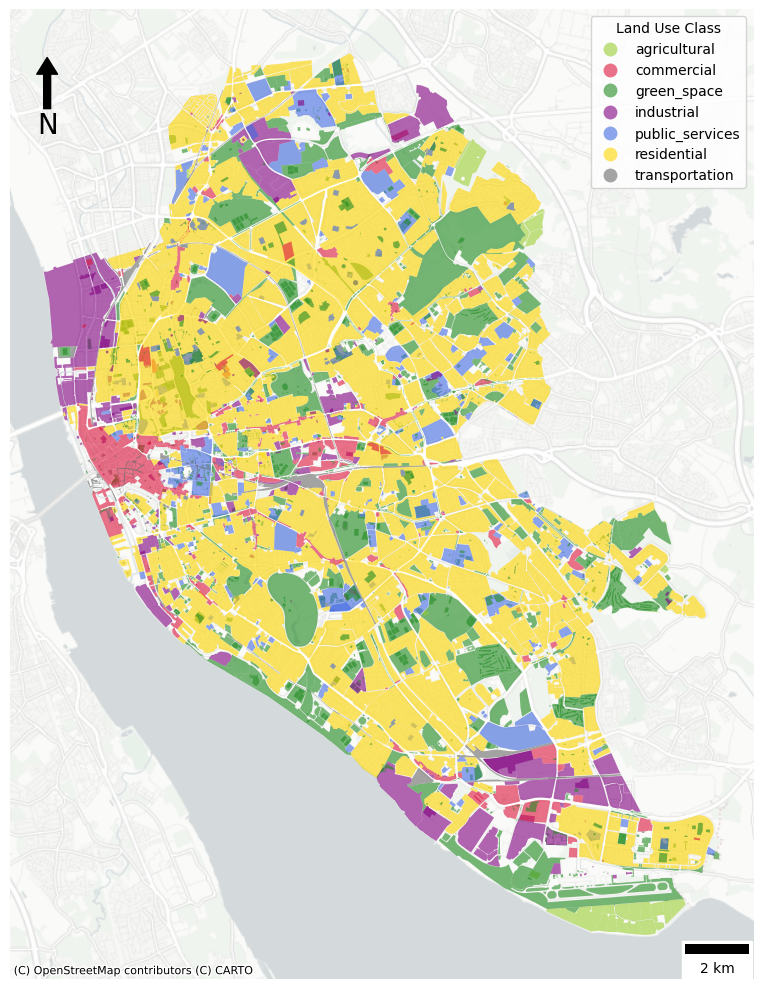

In [32]:
# Define a more distinct and accessible color palette
land_use_colors = {
    'green_space': '#228B22',      # Forest Green
    'residential': '#FFD700',      # Gold
    'industrial': '#800080',       # Purple
    'public_services': '#4169E1',  # Royal Blue
    'transportation': '#696969',   # Dim Gray
    'commercial': '#DC143C',       # Crimson
    'agricultural': '#9ACD32'      # Yellow Green
}

# Ensure colors are mapped to the sorted unique categories present in the data
categories = sorted(land_uses['land_use_class'].unique())
cmap = ListedColormap([land_use_colors.get(cat, '#000000') for cat in categories])

fig, ax = plt.subplots(figsize=(16, 10))
# Convert to Web Mercator for contextily compatibility
land_uses_3857 = land_uses.to_crs(epsg=3857)
land_uses_3857.plot(
    column='land_use_class',
    ax=ax,
    legend=True,
    categorical=True,
    cmap=cmap,
    alpha=0.6,
    legend_kwds={'loc': 'upper right', 'title': 'Land Use Class', 'frameon': True}
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

# Add scale bar (EPSG:3857 is in meters)
ax.add_artist(ScaleBar(1, location='lower right'))

# Add north mark
x, y, arrow_length = 0.05, 0.95, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords='axes fraction')

ax.set_axis_off()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "land_use.png"), bbox_inches='tight', pad_inches=0)

plt.show()


## 3. Metapath Visualization
Visualize graph metapaths with edge colors representing travel time.

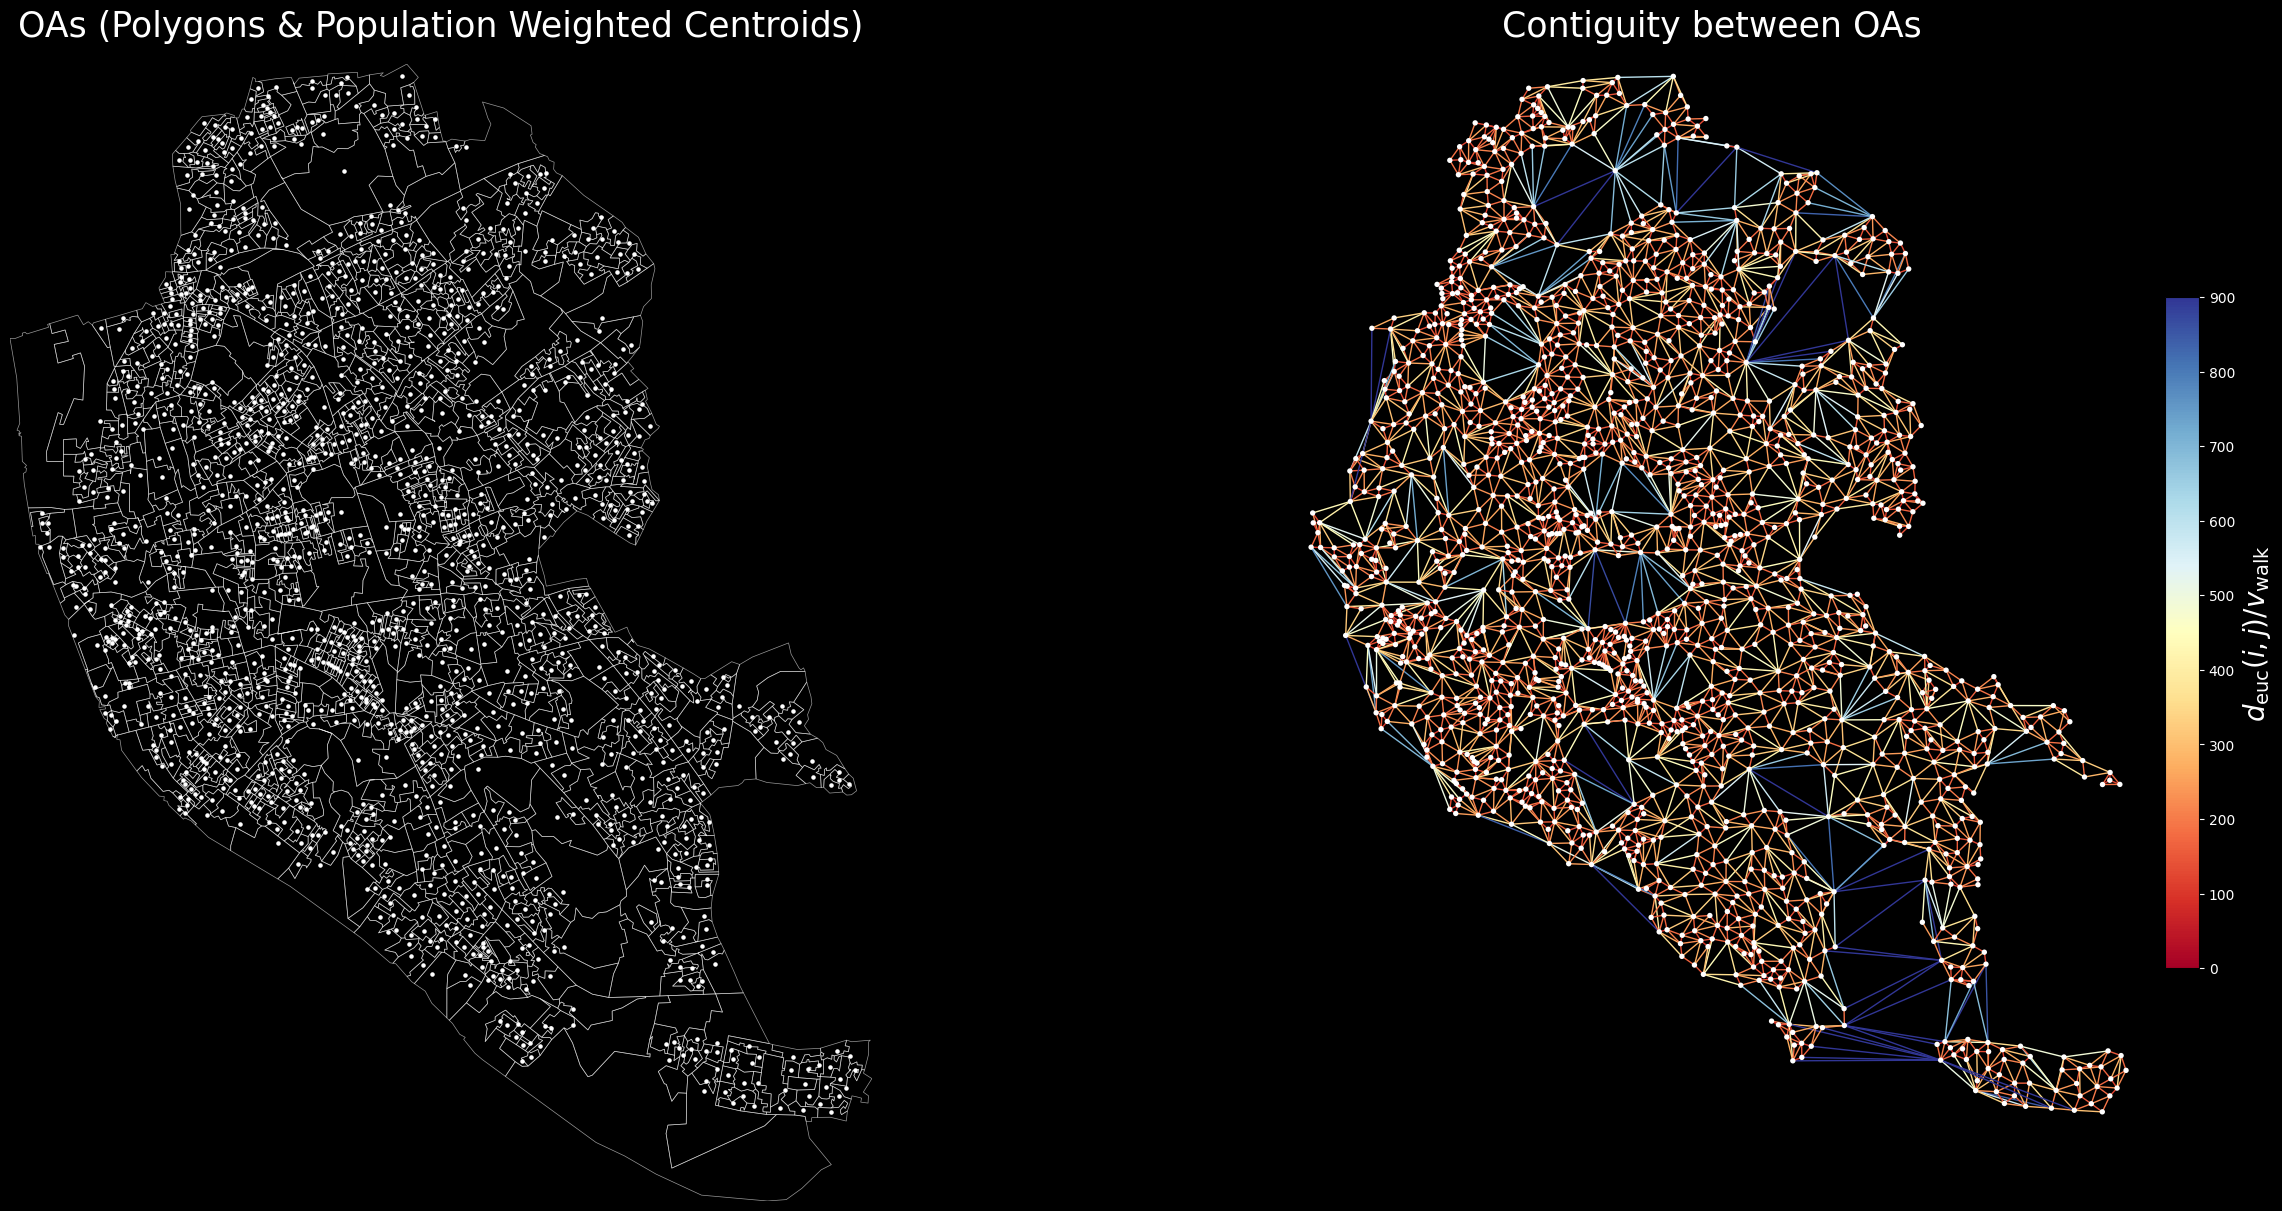

In [ ]:
import os
import sys
import torch
import torch_geometric
import city2graph as c2g
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
from shapely import wkt

# Load Graph Data (Hetero Multi)
# (Assuming GRAPHS_DIR and other paths are defined in previous cells or here)
graph_path = os.path.join(GRAPHS_DIR, "hetero_multi.pt")
data = torch.load(graph_path, weights_only=False)

hetero_nodes_multi, hetero_edges_multi = c2g.pyg_to_gdf(data)
hetero_edges_multi["oa", "contig", "oa"].index.names = ["u", "v"]

# Plot configuration
edge_types = [('oa', 'contig', 'oa'), ('oa', '15_min_walk', 'oa'), ('oa', '15_min_multi', 'oa')]
edge_lws = [1, 0.1, 0.05]
vmin, vmax = 0, 900
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.RdYlBu

# Prepare OA data
fpath = os.path.join(FEATURES_DIR, "oa_with_features.gpkg")
oa_polygons = gpd.read_file(fpath)
minx, miny, maxx, maxy = oa_polygons.total_bounds

# Process Weighted Centroids
node_gdf = oa_polygons.copy()
node_gdf.set_index("OA21CD", inplace=True)
node_gdf['geometry'] = gpd.GeoSeries.from_wkt(node_gdf['pop_weighted_centroid'])

# --- Figure 1: OA + Contiguity ---
fig1, axes1 = plt.subplots(1, 2, figsize=(24, 12), facecolor='black', constrained_layout=True)

# Subplot 1: OA Polygons & Weighted Centroids
ax = axes1[0]
ax.set_facecolor('black')
oa_polygons.plot(facecolor='none', edgecolor='white', linewidth=0.5, ax=ax, alpha=0.6)
node_gdf.plot(ax=ax, color='white', markersize=5, alpha=1)
ax.set_title("OAs (Polygons & Population Weighted Centroids)", color='white', fontsize=25, pad=20)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()

# Subplot 2: Contiguity Edges
ax = axes1[1]
ax.set_facecolor('black')
edge_type = edge_types[0] # ('oa', 'contig', 'oa')
lw = edge_lws[0]
df = hetero_edges_multi[edge_type]
edge_colors = [cmap(norm(val)) for val in df["travel_time_sec"]]

# Background OAs
oa_polygons.plot(facecolor='none', edgecolor='white', linewidth=0, ax=ax, alpha=0)

c2g.plot_graph(
    nodes={"oa": node_gdf},
    edges={edge_type: df},
    ax=ax,
    markersize=15,
    edge_linewidth={edge_type: lw},
    node_color="white",
    edge_color={edge_type: edge_colors},
    node_alpha=1,
    edge_alpha=1,
    bgcolor="black",
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig1.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
label = r'$d_{\text{euc}}(i,j) / v_{\text{walk}}$'
cbar.set_label(label, color='white', fontsize=20)
cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')
ax.set_title(f"Contiguity between OAs", color='white', fontsize=25, pad=20)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()

plt.savefig(os.path.join(FIGURES_DIR, "liverpool_contig.png"), bbox_inches='tight', pad_inches=0, facecolor='black')
plt.show()

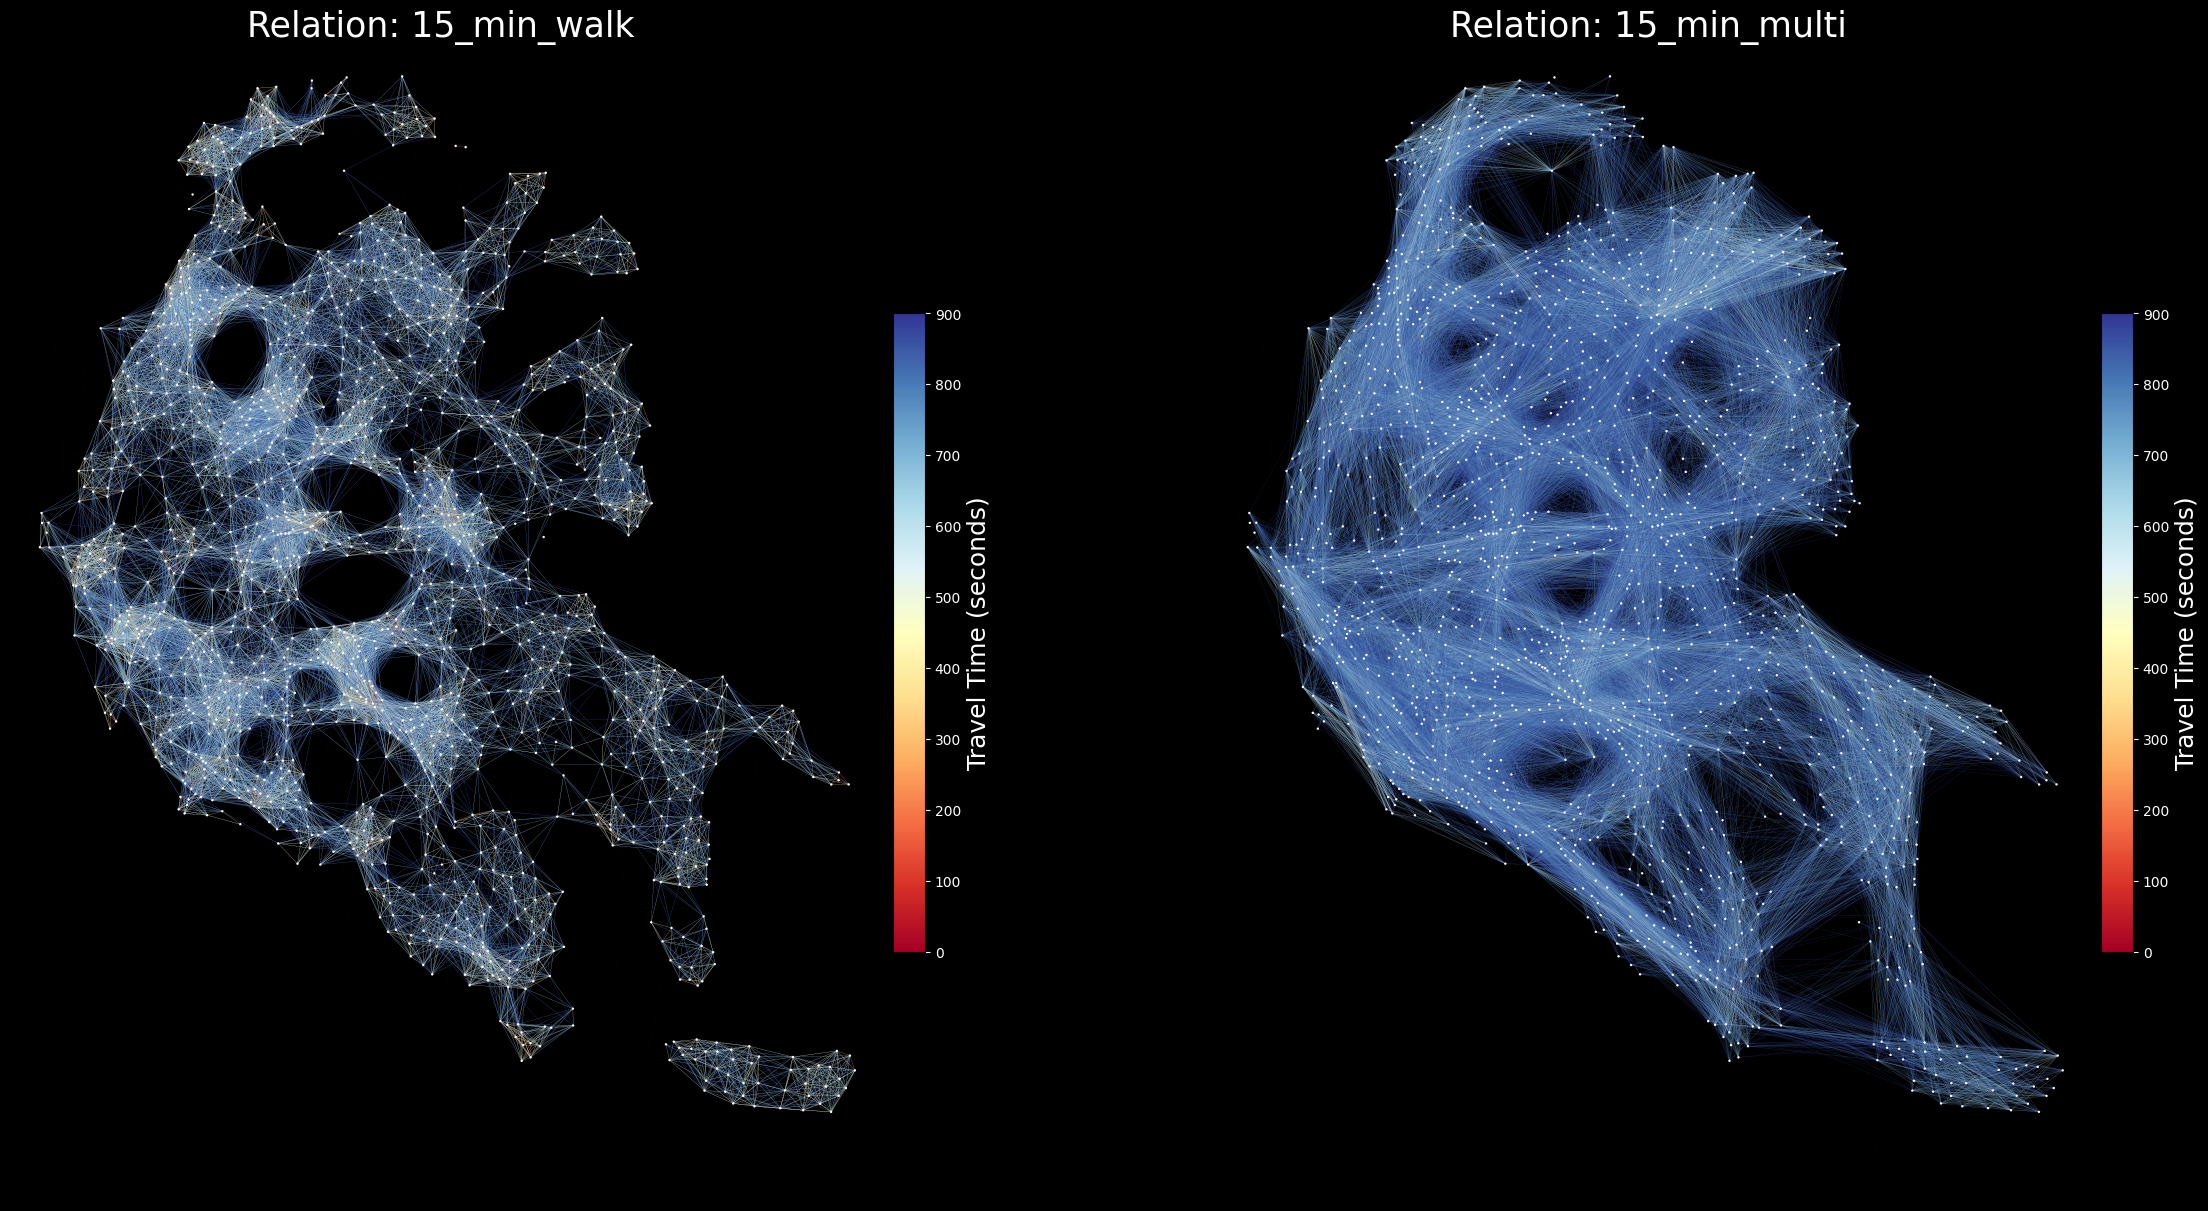

In [ ]:
# --- Figure 2: Metapaths (15min Walk + 15min Multi) ---
fig2, axes2 = plt.subplots(1, 2, figsize=(24, 12), facecolor='black', constrained_layout=True)

# Plot Remaining 2 relations
for i, idx in enumerate([1, 2]):
    ax = axes2[i]
    ax.set_facecolor('black')
    
    edge_type = edge_types[idx]
    lw = edge_lws[idx]
    df = hetero_edges_multi[edge_type]
    edge_colors = [cmap(norm(val)) for val in df["travel_time_sec"]]
    
    # Background OAs
    oa_polygons.plot(facecolor='none', edgecolor='white', linewidth=0.05, ax=ax, alpha=0.1)

    c2g.plot_graph(
        nodes={"oa": node_gdf},
        edges={edge_type: df},
        ax=ax,
        markersize=3,
        edge_linewidth={edge_type: lw},
        node_color="white",
        edge_color={edge_type: edge_colors},
        node_alpha=1,
        edge_alpha=1,
        bgcolor="black",
    )

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig2.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    
    label = "Travel Time (seconds)"
    cbar.set_label(label, color='white', fontsize=18)
    cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')
    
    ax.set_title(f"Relation: {edge_type[1]}", color='white', fontsize=25, pad=20)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_axis_off()

plt.savefig(os.path.join(FIGURES_DIR, "liverpool_metapaths.png"), bbox_inches='tight', pad_inches=0, facecolor='black')
plt.show()